In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
import os
from google.colab import files

In [5]:
uploaded=files.upload()

Saving dress-content.jpg to dress-content.jpg


In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

imsize = 512 if torch.cuda.is_available() else 128

In [109]:
def load_image(image_path, size):
    image = Image.open(image_path).convert('RGB')  # Convert to RGB to ensure 3 channels
    transform = transforms.Compose([
        transforms.Resize(size, Image.LANCZOS),
        transforms.ToTensor()
    ])
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

In [110]:
def dynamic_load_images(content_path, style_path, size):
    content_img = load_image(content_path, size)
    style_img = load_image(style_path, [content_img.size(2), content_img.size(3)])
    assert style_img.size() == content_img.size(), "Style and content images must be of the same size"
    return content_img, style_img

In [111]:
def show_image(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.pause(0.001)

In [112]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [113]:
def gram_matrix(input):
    batch_size, num_channels, height, width = input.size()
    features = input.view(batch_size * num_channels, height * width)
    G = torch.mm(features, features.t())
    return G.div(batch_size * num_channels * height * width)

In [114]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [115]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Mean and std for normalization
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [116]:
# Normalizing
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().requires_grad_(False).view(-1, 1, 1)
        self.std = std.clone().detach().requires_grad_(False).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [117]:
def get_model_and_losses(cnn, normalization_mean, normalization_std,
                         style_img, content_img,
                         content_layers=['conv_4'],
                         style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError(f'Unrecognized layer: {layer.__class__.__name__}')

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [17]:
uploaded=files.upload()

Saving tshirt-style-blue.jpg to tshirt-style-blue.jpg


In [118]:
content_path = 'dress-content.jpg'  # Change as needed
style_path = 'istockphoto-1363745772-612x612.jpg'  # Change as needed
content_img, style_img = dynamic_load_images(content_path, style_path, imsize)

In [119]:
def edge_detection(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (imsize, imsize), interpolation=cv2.INTER_LANCZOS4)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)  # Convert to 3 channels
    return edges

In [120]:
edges = edge_detection(content_path)
edges_pil = Image.fromarray(edges)
edges_tensor = transforms.ToTensor()(edges_pil).unsqueeze(0).to(device, torch.float)

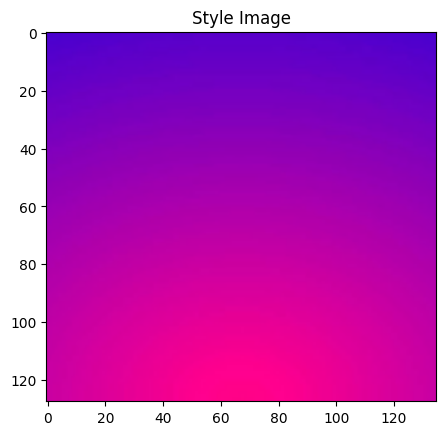

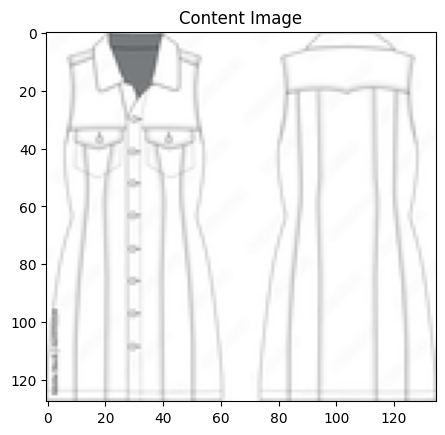

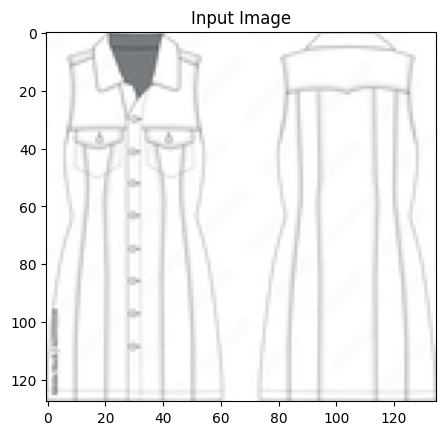

In [121]:
input_img = content_img.clone()

plt.figure()
show_image(style_img, title='Style Image')

plt.figure()
show_image(content_img, title='Content Image')

plt.figure()
show_image(input_img, title='Input Image')

In [44]:

uploaded=files.upload()

Saving istockphoto-1363745772-612x612.jpg to istockphoto-1363745772-612x612 (1).jpg


In [106]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [122]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    print('Building the style transfer model...')
    model, style_losses, content_losses = get_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing...')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            input_img.data.clamp_(0, 1)
            optimizer.zero_grad()
            model(input_img)
            style_score = sum(sl.loss for sl in style_losses)
            content_score = sum(cl.loss for cl in content_losses)

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            torch.nn.utils.clip_grad_norm_(input_img, max_norm=5.0)

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run[0]}:")
                print(f'Style Loss : {style_score.item()} Content Loss: {content_score.item()}')

            return style_score + content_score

        optimizer.step(closure)

    input_img.data.clamp_(0, 1)
    return input_img

Building the style transfer model...
Optimizing...
run 50:
Style Loss : 22906.033203125 Content Loss: 45.7492561340332
run 100:
Style Loss : 86029.8984375 Content Loss: 52.03915023803711
run 150:
Style Loss : 286000.15625 Content Loss: 52.53712844848633
run 200:
Style Loss : 86668.875 Content Loss: 46.280643463134766
run 250:
Style Loss : 111292.859375 Content Loss: 47.061012268066406
run 300:
Style Loss : 46590.69140625 Content Loss: 41.98970413208008


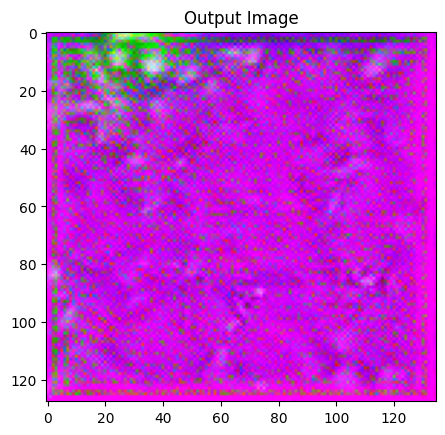

In [123]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=300)

plt.figure()
show_image(output, title='Output Image')

plt.ioff()
plt.show()